# Digit Recognizer Kaggle Challenge on MNIST Dataset

In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(2)
%matplotlib inline

In [221]:
train = pd.read_csv('data/train.csv')
X_test = pd.read_csv('data/test.csv')

## EDA

### First look at the data

In [222]:
print('Shape of training data: ', train.shape)
print('Shape of testing data: ', X_test.shape)

Shape of training data:  (42000, 785)
Shape of testing data:  (28000, 784)


In [223]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [224]:
X_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Missing Values

In [225]:
missing_values_train = np.sum(train.isna().sum())
missing_values_test = np.sum(X_test.isna().sum())

print(f'There are {missing_values_train} missing values in the training set.')
print(f'There are {missing_values_test} missing values in the testing set.')

There are 0 missing values in the training set.
There are 0 missing values in the testing set.


In [226]:
X_train = train.drop('label', axis=1)
y_train = train['label']

In [227]:
print('Shape of training data: ', X_train.shape)

Shape of training data:  (42000, 784)


### Visualize Numbers

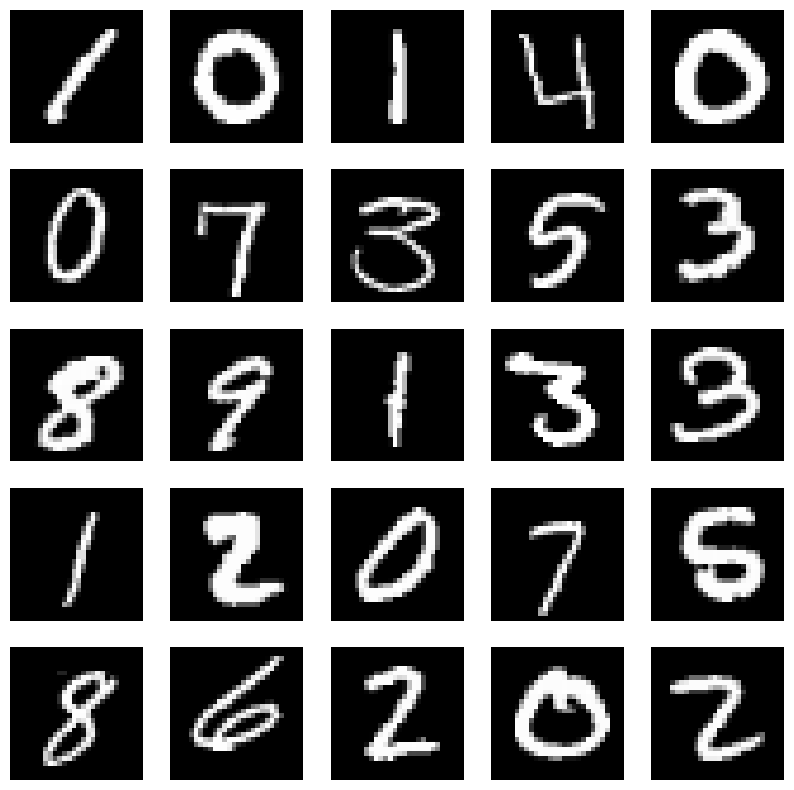

In [228]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train.iloc[i].values.reshape(28, 28), cmap='gray')
    ax.axis('off')

plt.show()

### Target Distribution

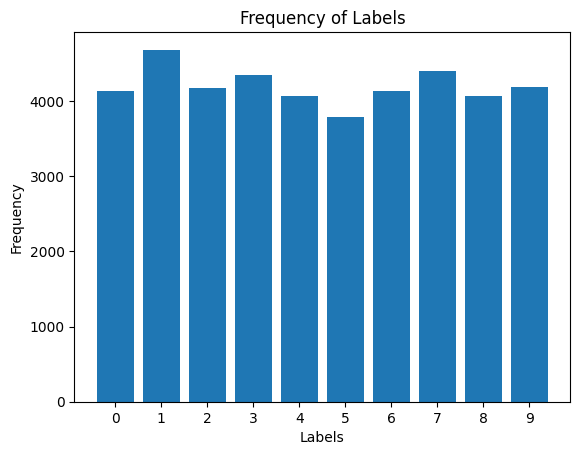

In [229]:
unique_labels, counts = np.unique(y_train, return_counts=True)

plt.bar(unique_labels, counts)

plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Frequency of Labels')

plt.xticks(unique_labels)

plt.show()

## Feature Engineering

### Normalize Features

In [230]:
X_train = X_train / 255.0
X_test = X_test / 255.0

### Reshape Features

In [231]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

### Reshape Target Variable

In [232]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
y_train = y_train.values.reshape(-1, 1)
y_train = encoder.fit_transform(y_train)

In [233]:
print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_train:', y_train.shape)

Shape of X_train: (42000, 28, 28, 1)
Shape of X_test: (28000, 28, 28, 1)
Shape of y_train: (42000, 10)


## Data Splitting

In [234]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=2)

In [235]:
print('Shape of X_train:', X_train.shape)
print('Shape of X_val:', X_val.shape)

Shape of X_train: (37800, 28, 28, 1)
Shape of X_val: (4200, 28, 28, 1)


## Data Augmentation

In [236]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Let's augment the data with these techniques:
    - Rotation
    - Horizontal Shift
    - Vertical Shift
    - Zoom

In [237]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

In [238]:
datagen.fit(X_train)

## Define Model

In [254]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

I have tested a few models before I came up with the one that is below. Here are the changes that improved model performance:
- Removing some of Pooling Layers
- Reducing dropout rate for Dropout Layers
- Adding strides parameter to Pooling Layer
- Replacing a few Dense Layers with the one with higher number of nodes

In [317]:
model = Sequential()

model.add(Conv2D(
    filters=32,
    kernel_size=(5, 5),
    padding='Same',
    activation='relu',
    input_shape=(28, 28, 1)))
model.add(Conv2D(
    filters=32,
    kernel_size=(5, 5),
    padding='Same',
    activation='relu'))
model.add(MaxPooling2D(
    pool_size=(2, 2)))

model.add(Conv2D(
    filters=64,
    kernel_size=(3, 3),
    padding='Same',
    activation='relu'))
model.add(Conv2D(
    filters=64,
    kernel_size=(3, 3),
    padding='Same',
    activation='relu'))
model.add(MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Define Optimizer
RMSprop is one of the best optimizers and a good first choice.

In [318]:
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


### learning Rate schedule
Let's also add Learning Rate Scheduler to our model to improve the results.

In [319]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

### Compile and Train the Model

In [320]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [321]:
batch_size = 86
epochs = 30

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_val, y_val),
    verbose=1,
    steps_per_epoch=X_train.shape[0] // batch_size,
    callbacks=[learning_rate_reduction])

Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


439/439 ━━━━━━━━━━━━━━━━━━━━ 39s 87ms/step - accuracy: 0.7463 - loss: 0.7659 - val_accuracy: 0.9812 - val_loss: 0.0634 - learning_rate: 0.0010
Epoch 2/30
  1/439 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - accuracy: 0.9535 - loss: 0.1056

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
2024-06-28 15:16:48.722539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9535 - loss: 0.1056 - val_accuracy: 0.9800 - val_loss: 0.0654 - learning_rate: 0.0010
Epoch 3/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.9624 - loss: 0.1281 - val_accuracy: 0.9821 - val_loss: 0.0614 - learning_rate: 0.0010
Epoch 4/30
  1/439 ━━━━━━━━━━━━━━━━━━━━ 37s 86ms/step - accuracy: 0.9884 - loss: 0.0559

2024-06-28 15:17:29.268986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9884 - loss: 0.0559 - val_accuracy: 0.9869 - val_loss: 0.0407 - learning_rate: 0.0010
Epoch 5/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 40s 92ms/step - accuracy: 0.9749 - loss: 0.0813 - val_accuracy: 0.9910 - val_loss: 0.0298 - learning_rate: 0.0010
Epoch 6/30
  1/439 ━━━━━━━━━━━━━━━━━━━━ 38s 88ms/step - accuracy: 0.9767 - loss: 0.0635

2024-06-28 15:18:10.902009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9767 - loss: 0.0635 - val_accuracy: 0.9905 - val_loss: 0.0291 - learning_rate: 0.0010
Epoch 7/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 41s 93ms/step - accuracy: 0.9803 - loss: 0.0651 - val_accuracy: 0.9919 - val_loss: 0.0238 - learning_rate: 0.0010
Epoch 8/30
  1/439 ━━━━━━━━━━━━━━━━━━━━ 38s 89ms/step - accuracy: 0.9884 - loss: 0.0470

2024-06-28 15:18:53.029702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9884 - loss: 0.0470 - val_accuracy: 0.9910 - val_loss: 0.0248 - learning_rate: 0.0010
Epoch 9/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 41s 93ms/step - accuracy: 0.9834 - loss: 0.0567 - val_accuracy: 0.9912 - val_loss: 0.0255 - learning_rate: 0.0010
Epoch 10/30
  1/439 ━━━━━━━━━━━━━━━━━━━━ 39s 90ms/step - accuracy: 0.9651 - loss: 0.0493

2024-06-28 15:19:35.299543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9651 - loss: 0.0493 - val_accuracy: 0.9919 - val_loss: 0.0256 - learning_rate: 0.0010
Epoch 11/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 42s 95ms/step - accuracy: 0.9842 - loss: 0.0510 - val_accuracy: 0.9936 - val_loss: 0.0224 - learning_rate: 0.0010
Epoch 12/30
  1/439 ━━━━━━━━━━━━━━━━━━━━ 39s 91ms/step - accuracy: 1.0000 - loss: 0.0215

2024-06-28 15:20:18.504784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.0215 - val_accuracy: 0.9940 - val_loss: 0.0229 - learning_rate: 0.0010
Epoch 13/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - accuracy: 0.9861 - loss: 0.0496 - val_accuracy: 0.9905 - val_loss: 0.0353 - learning_rate: 0.0010
Epoch 14/30
  1/439 ━━━━━━━━━━━━━━━━━━━━ 42s 97ms/step - accuracy: 0.9767 - loss: 0.0661

2024-06-28 15:21:04.176799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


439/439 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9767 - loss: 0.0661 - val_accuracy: 0.9907 - val_loss: 0.0338 - learning_rate: 0.0010
Epoch 15/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - accuracy: 0.9873 - loss: 0.0434 - val_accuracy: 0.9931 - val_loss: 0.0232 - learning_rate: 0.0010
Epoch 16/30
  1/439 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - accuracy: 0.9651 - loss: 0.1847

2024-06-28 15:21:53.018129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


439/439 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9651 - loss: 0.1847 - val_accuracy: 0.9938 - val_loss: 0.0196 - learning_rate: 0.0010
Epoch 17/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - accuracy: 0.9875 - loss: 0.0419 - val_accuracy: 0.9943 - val_loss: 0.0212 - learning_rate: 0.0010
Epoch 18/30
  1/439 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - accuracy: 1.0000 - loss: 0.0062

2024-06-28 15:22:43.148483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


439/439 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 0.9943 - val_loss: 0.0204 - learning_rate: 0.0010
Epoch 19/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - accuracy: 0.9889 - loss: 0.0377 - val_accuracy: 0.9912 - val_loss: 0.0393 - learning_rate: 0.0010
Epoch 20/30
  1/439 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/step - accuracy: 0.9884 - loss: 0.0327

2024-06-28 15:23:30.809579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


439/439 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9884 - loss: 0.0327 - val_accuracy: 0.9910 - val_loss: 0.0420 - learning_rate: 0.0010
Epoch 21/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - accuracy: 0.9900 - loss: 0.0371 - val_accuracy: 0.9948 - val_loss: 0.0199 - learning_rate: 0.0010
Epoch 22/30
  1/439 ━━━━━━━━━━━━━━━━━━━━ 43s 100ms/step - accuracy: 0.9767 - loss: 0.0813

2024-06-28 15:24:18.599826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


439/439 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9767 - loss: 0.0813 - val_accuracy: 0.9924 - val_loss: 0.0240 - learning_rate: 0.0010
Epoch 23/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - accuracy: 0.9886 - loss: 0.0410 - val_accuracy: 0.9933 - val_loss: 0.0309 - learning_rate: 0.0010
Epoch 24/30
  1/439 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/step - accuracy: 1.0000 - loss: 0.0044

2024-06-28 15:25:06.206397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


439/439 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 0.9933 - val_loss: 0.0336 - learning_rate: 0.0010
Epoch 25/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - accuracy: 0.9895 - loss: 0.0348 - val_accuracy: 0.9936 - val_loss: 0.0234 - learning_rate: 0.0010
Epoch 26/30
  1/439 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/step - accuracy: 0.9884 - loss: 0.0207

2024-06-28 15:25:53.946520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


439/439 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9884 - loss: 0.0207 - val_accuracy: 0.9924 - val_loss: 0.0284 - learning_rate: 0.0010
Epoch 27/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - accuracy: 0.9905 - loss: 0.0369 - val_accuracy: 0.9910 - val_loss: 0.0378 - learning_rate: 0.0010
Epoch 28/30
  1/439 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - accuracy: 0.9767 - loss: 0.0818

2024-06-28 15:26:41.156559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


439/439 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9767 - loss: 0.0818 - val_accuracy: 0.9931 - val_loss: 0.0265 - learning_rate: 0.0010
Epoch 29/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - accuracy: 0.9905 - loss: 0.0336 - val_accuracy: 0.9950 - val_loss: 0.0150 - learning_rate: 0.0010
Epoch 30/30
  1/439 ━━━━━━━━━━━━━━━━━━━━ 43s 100ms/step - accuracy: 1.0000 - loss: 0.0031

2024-06-28 15:27:28.922981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


439/439 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9952 - val_loss: 0.0159 - learning_rate: 0.0010


### Plot Accuracies and Losses of Last Trained Model

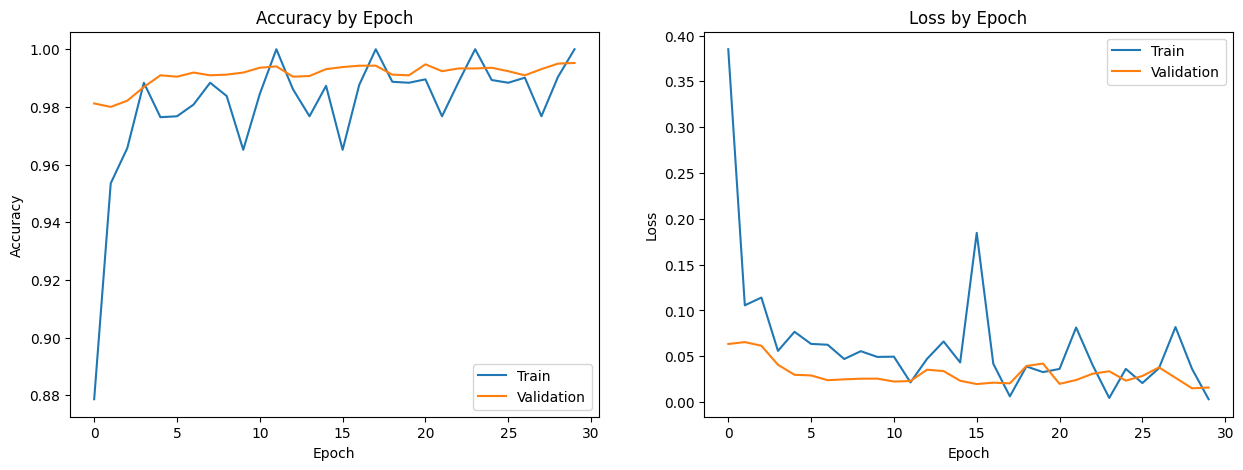

In [328]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Accuracy by Epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='lower right')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Loss by Epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [288]:
# histories = []

In [323]:
# histories.append(history)

### Print Average Validation Accuracy of the Models

Accuracy improved after almost every step of changes in the model. Note that models 5 and 6 are the same model trained for 10 and 30 epochs respectively.

In [324]:
for i, hist in enumerate(histories):
    mean_acc = np.mean(hist.history['val_accuracy'])
    print(f'Mean val accuracy of model {i+1}: {mean_acc}')

Mean val accuracy of model 1: 0.9617380976676941
Mean val accuracy of model 2: 0.9837142884731293
Mean val accuracy of model 3: 0.9858333349227906
Mean val accuracy of model 4: 0.985666674375534
Mean val accuracy of model 5: 0.9870000064373017
Mean val accuracy of model 6: 0.991269838809967


### Predict Results and Save to CSV File

In [325]:
results = model.predict(X_test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step


In [327]:
submission = pd.concat(
    [pd.Series(range(1,28001),name="ImageId"), results], axis=1)

submission.to_csv("cnn_mnist_datagen.csv", index=False)